# Natural Language Processing with Disaster Tweets

## Brief description of the problem and data

The goal of this problem is to build a machine learning model that predicts which tweets are about real disasters and which are not among those unclear real-time announcements.
Natural Language Processing gives machines the ability to read, understand and derive meaning from human languages. In this project, we will ensemble in NLP modeling to combine machine learning techniques with text, and using statistics to get the text in a format that the machine learning algorithm can understand.

### Importing Libraries and Data Set

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense
from tensorflow.keras import optimizers
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# Load Train and Test Data Set
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


The train data set is a tabulated data with 5 columns and 7613 rows. We could see the types of the columns and also find out that there are some null values in some columns. We will inspect more in EDA part about the data and pre-process it for the following process.

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [4]:
# Check how many 0 (non disaster) and 1 (disaster) in the target column.
train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

<Axes: xlabel='target', ylabel='count'>

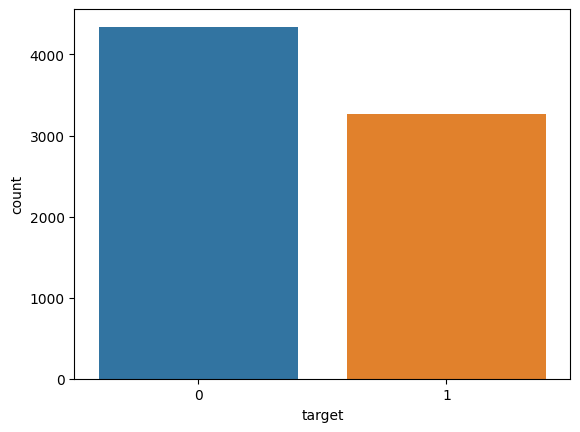

In [5]:
sns.countplot(x='target', data=train)

There are 4324 values for the target of 0 (non disaster) and 3271 values for the target of 1 (disaster).

<Axes: xlabel='number_of_words', ylabel='Count'>

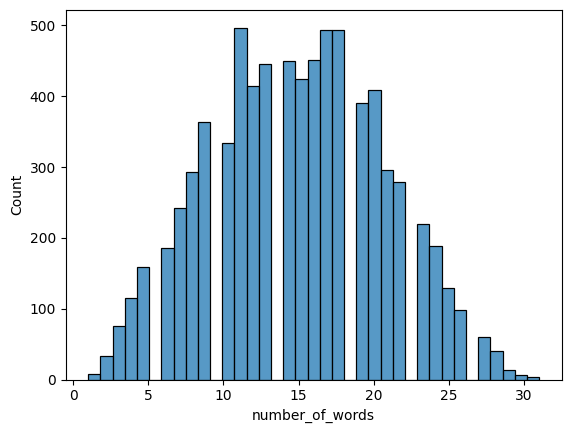

In [6]:
# Check the distribution of the number of the words.
def count_words(x):
    return len(x.split())
train['number_of_words'] = train['text'].apply(count_words)
sns.histplot(train['number_of_words'])

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

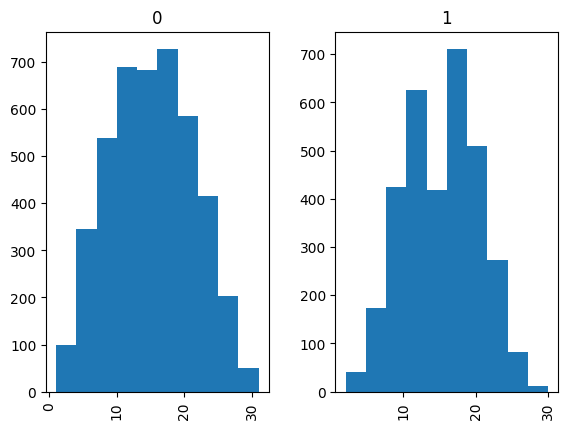

In [7]:
train.hist(column='number_of_words', by='target')

### Text Preprocessing

In [8]:
# Remove URL, HTML, emoji, number, and punctuation in the text.
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)

def remove_HTML(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji = re.compile('['
                       u'\U0001F600-\U0001F64F'
                       u'\U0001F300-\U0001F3FF'
                       u'\U0001F680-\U0001F6FF'
                       u'\U0001F1E0-\U0001F1FF'
                       u'\U00002702-\U000027B0'
                       u'\U000024C2-\U0001F251'
                       ']+', flags=re.UNICODE)
    return emoji.sub(r'',text)

def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER',text)

def remove_punctuation(text):
    text = ''.join([char for char in text if char not in string.punctuation])
    return text

In [9]:
def preprocess(text):
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_emoji(text)
    text = remove_number(text)
    text = remove_punctuation(text)
    
    return text

In [10]:
train['clean_text'] = train['text'].apply(preprocess)
test['clean_text'] = test['text'].apply(preprocess)

In [11]:
train.head()

,id,keyword,location,text,target,number_of_words,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,Our Deeds are the Reason of this earthquake Ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,All residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,NUMBER people receive wildfires evacuation ord...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,Just got sent this photo from Ruby Alaska as s...


In [12]:
# Tokenizer with the max feature of 3000.
max_features = 3000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(train['clean_text'].values)
x = tokenizer.texts_to_sequences(train['clean_text'].values)
x = pad_sequences(x)

In [13]:
y = train['target']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

## Model Architecture

In [14]:
# Build a model with the dimensions of 32.
emb_dim = 32
lstm_out = 32

model = Sequential()
model.add(Embedding(max_features, emb_dim, input_length=x.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out,dropout=0.2, recurrent_dropout=0.4))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.002)
model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 31, 32)            96000     
                                                                 
 dropout (Dropout)           (None, 31, 32)            0         
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 104353 (407.63 KB)
Trainable params: 104353 (407.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [15]:
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test,y_test))

Epoch 1/10
191/191 [==============================] - 7s 23ms/step - loss: 0.5339 - accuracy: 0.7299 - val_loss: 0.4360 - val_accuracy: 0.8122
Epoch 2/10
191/191 [==============================] - 4s 21ms/step - loss: 0.3762 - accuracy: 0.8402 - val_loss: 0.4527 - val_accuracy: 0.8076
Epoch 3/10
191/191 [==============================] - 4s 22ms/step - loss: 0.3248 - accuracy: 0.8683 - val_loss: 0.4789 - val_accuracy: 0.7859
Epoch 4/10
191/191 [==============================] - 4s 21ms/step - loss: 0.2880 - accuracy: 0.8823 - val_loss: 0.5314 - val_accuracy: 0.7682
Epoch 5/10
191/191 [==============================] - 4s 21ms/step - loss: 0.2598 - accuracy: 0.8939 - val_loss: 0.5598 - val_accuracy: 0.7846
Epoch 6/10
191/191 [==============================] - 4s 21ms/step - loss: 0.2304 - accuracy: 0.9090 - val_loss: 0.5735 - val_accuracy: 0.7800
Epoch 7/10
191/191 [==============================] - 4s 21ms/step - loss: 0.1982 - accuracy: 0.9235 - val_loss: 0.6227 - val_accuracy: 0.7833

In [16]:
y_pred = model.predict(x_test).round()

48/48 [==============================] - 0s 4ms/step


## Results and Analysis

In [17]:
train_accuracy = metrics.accuracy_score(y_train, model.predict(x_train).round())
print(train_accuracy)

191/191 [==============================] - 1s 4ms/step
0.9620689655172414


In [18]:
test_accuracy = metrics.accuracy_score(y_test, y_pred)
test_recall = metrics.recall_score(y_test, y_pred)
test_precision = metrics.precision_score(y_test, y_pred)
print('Accuracy: ', test_accuracy)
print('Recall: ', test_recall)
print('Precision: ', test_precision)

Accuracy:  0.7596848325673013
Recall:  0.711864406779661
Precision:  0.7207488299531981


In [19]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.79      0.80      0.79       874
           1       0.72      0.71      0.72       649

    accuracy                           0.76      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523



<Axes: >

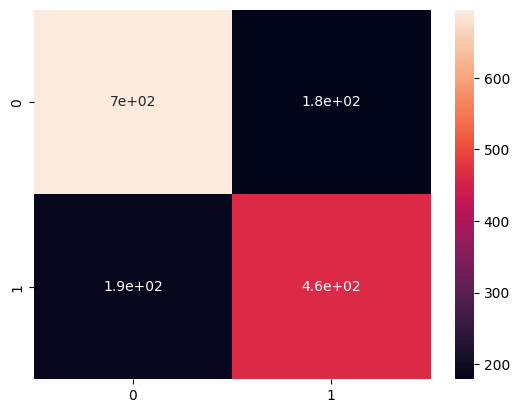

In [20]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

### Try Different Architecture for Comparison

In [21]:
# Change the max feature to 5000.
new_max_features = 5000
tokenizer = Tokenizer(num_words=new_max_features, split=' ')
tokenizer.fit_on_texts(train['clean_text'].values)
new_x = tokenizer.texts_to_sequences(train['clean_text'].values)
new_x = pad_sequences(new_x, maxlen=50)

In [22]:
# Change the dimensions to 100.
new_emb_dim = 100
new_lstm_out = 100

new_model = Sequential()
new_model.add(Embedding(new_max_features, new_emb_dim, input_length=new_x.shape[1]))
new_model.add(Dropout(0.2))
new_model.add(LSTM(new_lstm_out, dropout=0.2, return_sequences=True, recurrent_dropout=0.4))
new_model.add(Dropout(0.2))
new_model.add(LSTM(new_lstm_out, dropout=0.2, recurrent_dropout=0.2))
new_model.add(Dropout(0.2))
new_model.add(Dense(1,activation='sigmoid'))
new_adam = optimizers.Adam(learning_rate=2e-3)
new_model.compile(loss='binary_crossentropy',optimizer=new_adam, metrics=['accuracy'])
print(new_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 100)           500000    
                                                                 
 dropout_1 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 100)           80400     
                                                                 
 dropout_2 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [23]:
new_model.fit(new_x, y, epochs=10, batch_size=32, validation_split=0.2)
new_train_accuracy = metrics.accuracy_score(y, new_model.predict(new_x).round())
print(new_train_accuracy)

Epoch 1/10
191/191 [==============================] - 24s 99ms/step - loss: 0.5143 - accuracy: 0.7494 - val_loss: 0.4490 - val_accuracy: 0.7984
Epoch 2/10
191/191 [==============================] - 18s 97ms/step - loss: 0.3615 - accuracy: 0.8521 - val_loss: 0.4606 - val_accuracy: 0.7859
Epoch 3/10
191/191 [==============================] - 18s 97ms/step - loss: 0.2888 - accuracy: 0.8851 - val_loss: 0.5209 - val_accuracy: 0.7748
Epoch 4/10
191/191 [==============================] - 18s 96ms/step - loss: 0.2286 - accuracy: 0.9118 - val_loss: 0.6123 - val_accuracy: 0.7663
Epoch 5/10
191/191 [==============================] - 19s 97ms/step - loss: 0.1826 - accuracy: 0.9297 - val_loss: 0.6877 - val_accuracy: 0.7630
Epoch 6/10
191/191 [==============================] - 19s 98ms/step - loss: 0.1444 - accuracy: 0.9419 - val_loss: 0.7967 - val_accuracy: 0.7577
Epoch 7/10
191/191 [==============================] - 18s 96ms/step - loss: 0.1310 - accuracy: 0.9486 - val_loss: 0.8640 - val_accuracy:

### Create a Submission

Based on the accuracy results from the first and the second model with different parameters and the architectures, we will create a submission with the First model.

In [24]:
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(train['clean_text'].values)
test_token = tokenizer.texts_to_sequences(test['clean_text'].values)
test_token = pad_sequences(test_token)
y_hat = model.predict(test_token).round()

102/102 [==============================] - 1s 4ms/step


In [25]:
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission['target'] = np.round(y_hat).astype('int')
submission.to_csv('submission.csv', index=False)
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


<Axes: xlabel='target', ylabel='count'>

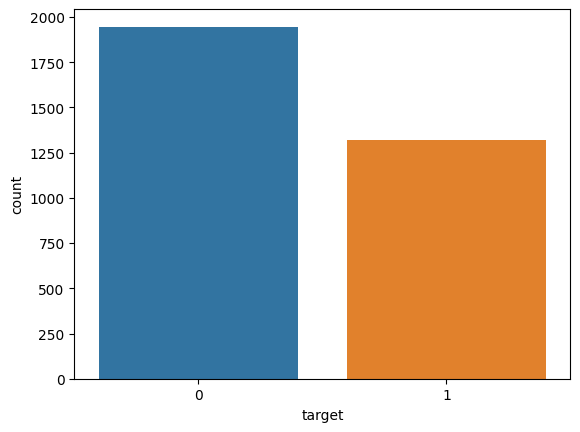

In [26]:
sns.countplot(x='target', data=submission)

## Conclusion

In this project, we initially had 7613 features of tweets which had id, keyword, location, text, and target information. For using text to analyze to see if the tweet is related to disaster, we first inspected the data more and visualized it using histograms. After that, we preprocessed the text data by removing some features such as URL, HTML, emoji, number, and punctuation.
The first model built was with the embedding layer of size (3000,32) and Long Short Term Memory. That model gave us the prediction accuracy of 0.96. We tried the other model with different parameters and got the accuracy of 0.93.
With the first model, we could predict the target values for each id in sample submission file.

### Discussion for Future Improvement

The process of the project was successful and was doing well for making predictions. However, there is still possibility to do a better analysis. In the preprocessing stage, we did not remove any rows which could affect the quality of the analysis. Also, we removed noise such as punctuations and emojis from the text, but not stopwords. The process could have done better if there was tighter work fot the text preprocessing.